less is more - kaggle santander

# start

from 0319_2 add max_delta_step=1

In [1]:
PRFX='0319_3_2'
trntmstmp=1584412344
valtmstmp=1584626395
import datetime
[datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (trntmstmp, valtmstmp)]

['2020-03-17 02:32:24', '2020-03-19 13:59:55']

# setup

In [2]:
from pathlib import Path
import dask
print('dask.__version__', dask.__version__)
import xgboost as xgb
import dask_xgboost
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from dask.distributed import Client
import pickle
import lightgbm as lgb
from tqdm import tqdm

import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=[
'toks',
'hshtgs',
'twtid',
'media',
'links',
'domns',
'twttyp',
'lang',
'tm',

'u1id',
'u1_fllwer_cnt',
'u1_fllwing_cnt',
'u1_vrfed',
'u1_create_tm',

'u2id',
'u2_follower_cnt',
'u2_following_cnt',
'u2_vrfed',
'u2_create_tm',

'u1_fllw_u2',
'reply_tm',
'retwt_tm',
'retwt_cmmnt_tm',
'like_tm',
]

cols_val = cols[:-4]
cols_tgt_tmstmp=[
    'retwt_tm',
    'reply_tm',
    'like_tm',
    'retwt_cmmnt_tm',
]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
ntgts=len(tgts)

dask.__version__ 2.12.0


# prepare data

## get maps from dfval

In [3]:
# dfval=dd.read_csv(
#     f'{p_in}/val_{valtmstmp}.tsv',
#     sep='\x01', header=None, names=cols_val,)
# lang2cnt=dict(dfval.lang.value_counts().compute())
# ttl=sum(lang2cnt.values())
# lang2perc={k:v/ttl for k,v in lang2cnt.items()}
langs=['D3164C7FBCF2565DDF915B1B3AEFB1DC', '22C448FF81263D4BAF2A176145EE9EAD', '06D61DCBBE938971E1EA0C38BD9B5446', 'ECED8A16BE2A5E8871FD55F4842F16B1', 'B9175601E87101A984A50F8A62A1C374', '4DC22C3F31C5C43721E6B5815A595ED6', '167115458A0DBDFF7E9C0C53A83BAC9B', '125C57F4FA6D4E110983FB11B52EFD4E', '022EC308651FACB02794A8147AEE1B78', 'FA3F382BC409C271E3D6EAF8BE4648DD', '9BF3403E0EB7EA8A256DA9019C0B0716', '975B38F44D65EE42A547283787FF5A21', '2996EB2FE8162C076D070A4C8D6532CD', 'FF60A88F53E63000266F8B9149E35AD9', '717293301FE296B0B61950D041485825', '3E16B11B7ADE3A22DDFC4423FBCEAD5D', '3820C29CBCA409A33BADF68852057C4A', '9ECD42BC079C20F156F53CB3B99E600E', '76B8A9C3013AE6414A3E6012413CDC3B', 'AEF22666801F0A5846D853B9CEB2E327', '190BA7DA361BC06BC1D7E824C378064D', '1FFD2FE4297F5E70EBC6C3230D95CB9C', 'A0C7021AD8299ADF0C9EBE326C115F6F', 'D413F5FE5236E5650A46FD983AB39212', '48236EC80FDDDFADE99420ABC9210DDF', '691890251F2B9FF922BE6D3699ABEFD2', '920502FAA080485768AA89BC96A55C47', '0331BF70E606D62D92C96CE9AD71A7CF', '89616CFF8EC8637092F885C7EFF43D74', '06BEAB41D66CCFF329D1ED8BA120A6C2', '60FBA0E834CC59D647C3599AD763FFDF', 'C7A400D9AD489ACF673CF12FBB80AAE5', 'E59EF8BB86A6D815331DDF4C467CE0C7', '4249CE88433AEA3F8DCEECF008B3CB95', '544FA32458C903F1125FE6598300A047', 'CB11E9CF42BD0A1BAD5E27BF3422D99D', '3A85BCEC571C3F5AB1069E4924189177', 'FF7EABB5A382356D54D9C41BA0125E09', 'E7BB61D2A87C1E72DF1C7BC292B86A1C', '69C4A33B9AD29AF883D60BA61CC08702', 'F4FD40A716F1572C9A28E9CAA58BE3A5', '259A6F6DFD672CB1F883CBEC01B99F2D', '6431A618DCF7F4CB7F62A95A39BAB77A', '3121F7240D488F74EEED9312E174B217', '54208B51D44E7D91DC2F3DD02ADEDEC2', 'DBEEFB80F8A314311E2B4BD593E11DFE', 'B6D90127A09AB1229731898AEF9D4D7C', 'F3E1016563360F9434FA986CA86C249C', '2216D01F7B48554E4211021A46816FCF', '1BC639981AE88E09129594B11F894A21', 'C942E369C88CE7C56E69A84D04319FF0', '57ADD4576E2AD6648E9B2DE32F3462A5', 'AC1F0671A4B0D5B8112F87DE7B490E6D', 'C2EF5FABE7619D8A333D5F0FF76E1BFA', 'AA0254541959271ED3453119B787D0C3', 'A6B70CDF8C7B934D4A218CA9B6B7FDB4', 'BF477808A37E3E4E9C5D9F1839E8519E', '97F81BD92A1ACA3F1F43C154E689350F', '60A3DB168094D41241E45E0DE3539BC0', '12D8CEB94F89D11D7EB95EAE9689B009', 'F73266A79468BB89C4325FDEDB0B533C', '4690215948DBF6872B8ED1C2BC87B17E', 'D18801336202297E6484F634CAC6592E', '2E18F6F53E3CF073911AF0A93BBE5373', 'B2235C8B73239FDC5780DD132419833A', '515E873C86EE1577E75FA2387B7FA59E',]

# dfval.twttyp.value_counts().compute()
# TopLevel    2932
# Retweet      994
# Quote        213
twttyps=['TopLevel','Retweet','Quote']

In [4]:
def prp_df(df):
    df['len_toks']=df.toks.apply(len)
    for media in ['Photo', 'Video', 'GIF']:
        df[f'has_media_{media}'] = df.media.fillna('').apply(lambda x: media in x)
    for col in ['hshtgs', 'links', 'domns',]:
        df[f'num_{col}'] = df[col].fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0)
    tm_dt=pd.to_datetime(df.tm, unit='s')
    df['tm_month']=tm_dt.dt.month
    df['tm_dayofweek']=tm_dt.dt.dayofweek
    df['tm_day']=tm_dt.dt.day
    df['tm_hour']=tm_dt.dt.hour
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    for typ in twttyps:
        df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')

    for lang in langs:
        df[f'lang_{lang}']=(df.lang==lang).astype('int8')
    df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 'u1id',], )
    return df

In [5]:
chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                    header=None,names=cols, 
                        chunksize=1e6
                       )

lst_df = []
for ichnk,df in enumerate(chnks_trn):
    print(dtnow(), 'chunk', ichnk)
    df = prp_df(df)
    
    idx0    =np.where(df[cols_tgt_tmstmp].notna().sum(1)==0)[0]
    idx1    =np.where(df[cols_tgt_tmstmp].notna().sum(1)==1)[0]
    idx2    =np.where(df[cols_tgt_tmstmp].notna().sum(1)>1)[0]
        
    df0=df.iloc[idx0].copy()
    df0['tgt']=ntgts
    df1=df.iloc[idx1].copy()
    df1['tgt']=np.argmax(df1[cols_tgt_tmstmp].notna().values, 1)
    
    df2_=df.iloc[idx2]
    rows_new=[]
    for _, row in tqdm(df2_.iterrows(), total=len(df2_)):
        idx_tgt = np.where(row[cols_tgt_tmstmp].notna())[0]
        for i_tgt in idx_tgt:
            row_new = row.copy()
            row_new['tgt']=i_tgt
            rows_new.append(row_new)
    df2=pd.DataFrame(rows_new)
    
    df=pd.concat([df0,df1,df2])
    df.drop(inplace=True, columns=['reply_tm', 'retwt_tm', 'retwt_cmmnt_tm', 'like_tm',])

    lst_df.append(df)
    
    break


2020-03-20 03:04:02 chunk 0


100%|██████████| 71453/71453 [05:36<00:00, 212.49it/s]


In [6]:
# pd.set_option('display.max_rows', 100)

# display(df0[['twtid']+cols_tgt_tmstmp+['tgt']].head(20))
# display(df1[['twtid']+cols_tgt_tmstmp+['tgt']].head(20))
# display(df2[['twtid']+cols_tgt_tmstmp+['tgt']].head(20))

In [7]:
df = pd.concat(lst_df)

In [8]:
df.shape

(1076428, 96)

In [9]:
df.columns

Index(['twtid', 'tm', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_follower_cnt', 'u2_following_cnt',
       'u2_vrfed', 'u2_create_tm', 'u1_fllw_u2', 'len_toks', 'has_media_Photo',
       'has_media_Video', 'has_media_GIF', 'num_hshtgs', 'num_links',
       'num_domns', 'tm_month', 'tm_dayofweek', 'tm_day', 'tm_hour',
       'tmdlta_u2u1', 'tmdlta_twtu1', 'tmdlta_twtu2', 'twttyp_TopLevel',
       'twttyp_Retweet', 'twttyp_Quote',
       'lang_D3164C7FBCF2565DDF915B1B3AEFB1DC',
       'lang_22C448FF81263D4BAF2A176145EE9EAD',
       'lang_06D61DCBBE938971E1EA0C38BD9B5446',
       'lang_ECED8A16BE2A5E8871FD55F4842F16B1',
       'lang_B9175601E87101A984A50F8A62A1C374',
       'lang_4DC22C3F31C5C43721E6B5815A595ED6',
       'lang_167115458A0DBDFF7E9C0C53A83BAC9B',
       'lang_125C57F4FA6D4E110983FB11B52EFD4E',
       'lang_022EC308651FACB02794A8147AEE1B78',
       'lang_FA3F382BC409C271E3D6EAF8BE4648DD',
       'lang_9BF3403E0EB7EA8A256DA9019C0B0716',


In [10]:
cols_feat=[o for o in df.columns if o not in ('tgt', 'twtid', 'u1id', 'u2id',)]

In [11]:
X=df[cols_feat].values
y=df['tgt'].values

In [12]:
Xtr,Xvl,ytr,yvl = train_test_split(X, y, test_size=0.15, random_state=SEED)

# model

In [13]:
params = {
    'objective': 'multi:softprob',
    'num_class': ntgts+1,
    'verbosity': 1,
    'eval_metric': ['mlogloss',],
#     https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
    'max_delta_step': 1,
}
num_rounds = 60


In [14]:
dtr = xgb.DMatrix(Xtr, label=ytr, feature_names=cols_feat)
dvl = xgb.DMatrix(Xvl, label=yvl, feature_names=cols_feat)
evallist = [(dtr, 'eval'), (dvl, 'train')]
bst = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds, evals=evallist, early_stopping_rounds=10)
# bst = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds,)

[0]	eval-mlogloss:1.42631	train-mlogloss:1.42727
Multiple eval metrics have been passed: 'train-mlogloss' will be used for early stopping.

Will train until train-mlogloss hasn't improved in 10 rounds.
[1]	eval-mlogloss:1.29865	train-mlogloss:1.30038
[2]	eval-mlogloss:1.21228	train-mlogloss:1.21471
[3]	eval-mlogloss:1.15236	train-mlogloss:1.15546
[4]	eval-mlogloss:1.10898	train-mlogloss:1.11262
[5]	eval-mlogloss:1.07706	train-mlogloss:1.08119
[6]	eval-mlogloss:1.05261	train-mlogloss:1.05708
[7]	eval-mlogloss:1.03369	train-mlogloss:1.03862
[8]	eval-mlogloss:1.01929	train-mlogloss:1.02468
[9]	eval-mlogloss:1.00754	train-mlogloss:1.01331
[10]	eval-mlogloss:0.99797	train-mlogloss:1.00403
[11]	eval-mlogloss:0.99066	train-mlogloss:0.99709
[12]	eval-mlogloss:0.98451	train-mlogloss:0.99128
[13]	eval-mlogloss:0.97912	train-mlogloss:0.98625
[14]	eval-mlogloss:0.97483	train-mlogloss:0.98228
[15]	eval-mlogloss:0.97114	train-mlogloss:0.97887
[16]	eval-mlogloss:0.96830	train-mlogloss:0.97635
[17]	ev

In [15]:
def show_feat_importance(bst):
    ax = xgb.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title('Estimated feature importance')
    plt.show()


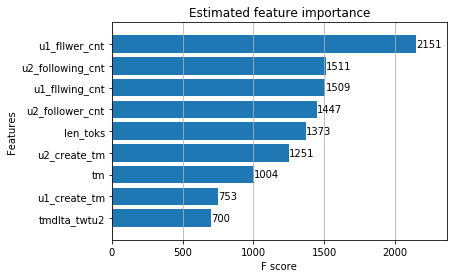

In [16]:
show_feat_importance(bst)

In [17]:
feat2importance=bst.get_fscore()
pd.DataFrame([feat2importance.keys(), feat2importance.values()]).T.sort_values(1, ascending=False).head(20)

,0,1
6,u1_fllwer_cnt,2151
9,u2_following_cnt,1511
15,u1_fllwing_cnt,1509
1,u2_follower_cnt,1447
7,len_toks,1373
8,u2_create_tm,1251
18,tm,1004
23,u1_create_tm,753
12,tmdlta_twtu2,700
14,tmdlta_u2u1,685


In [18]:
bst.save_model(f'{p_out}/bst_{PRFX}.model')


In [19]:
bst.load_model(f'{p_out}/bst_{PRFX}.model') 


In [20]:
prdtr = bst.predict(dtr)
prdvl = bst.predict(dvl)

In [21]:
tgt2auc_trn={}
tgt2rce_trn={}
tgt2auc_val={}
tgt2rce_val={}
for itgt, tgt in enumerate(tgts):
    print(tgt)
    prdtr_i, prdvl_i = (prd[:,itgt] for prd in (prdtr,prdvl))
    ytr_i, yvl_i = ((y==itgt).astype(int) for y in (ytr,yvl))
    scr_rocauc_trn = roc_auc_score(ytr_i, prdtr_i)
    scr_rocauc_val = roc_auc_score(yvl_i, prdvl_i)
    scr_auc_trn=compute_prauc(prdtr_i, ytr_i)
    scr_rce_trn=compute_rce(prdtr_i, ytr_i)
    scr_auc_val=compute_prauc(prdvl_i, yvl_i)
    scr_rce_val=compute_rce(prdvl_i, yvl_i)

    tgt2auc_trn[tgt]=scr_auc_trn
    tgt2rce_trn[tgt]=scr_rce_trn
    tgt2auc_val[tgt]=scr_auc_val
    tgt2rce_val[tgt]=scr_rce_val
    
    print('train rocauc:', f'{scr_rocauc_trn:.4f}', 'valid auc:', f'{scr_rocauc_val:.4f}', )
    print('train prauc:', f'{scr_auc_trn:.4f}', 'valid auc:', f'{scr_auc_val:.4f}', )
    print('train rce:', f'{scr_rce_trn:.4f}', 'valid rce:', f'{scr_rce_val:.4f}', )

Retweet
train rocauc: 0.7392 valid auc: 0.7196
train prauc: 0.2947 valid auc: 0.2644
train rce: 11.5632 valid rce: 9.6926
Reply
train rocauc: 0.7977 valid auc: 0.7659
train prauc: 0.1227 valid auc: 0.0907
train rce: 13.3059 valid rce: 10.2989
Like
train rocauc: 0.7215 valid auc: 0.7132
train prauc: 0.6287 valid auc: 0.6167
train rce: 11.3654 valid rce: 10.5304
RTwCmnt
train rocauc: 0.7809 valid auc: 0.7016
train prauc: 0.0513 valid auc: 0.0164
train rce: 9.2489 valid rce: 4.3239


In [22]:
lsttrn=[]
lstval=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    lsttrn+=[(f'PRAUC {tgt}',tgt2auc_trn[tgt]),
          (f'RCE {tgt}',tgt2rce_trn[tgt])]
    lstval+=[(f'PRAUC {tgt}',tgt2auc_val[tgt]),
          (f'RCE {tgt}',tgt2rce_val[tgt])]

dfscrtrn=pd.DataFrame(lsttrn)
dfscrtrn.columns=['metric','scr']
dfscrval=pd.DataFrame(lstval)
dfscrval.columns=['metric','scr']
dfscr = pd.merge(dfscrtrn, dfscrval, on='metric', suffixes=('trn','val'))
dfscr.T

,0,1,2,3,4,5,6,7
metric,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
scrtrn,0.294694,11.5632,0.122672,13.3059,0.628714,11.3654,0.051288,9.24894
scrval,0.264417,9.69265,0.0907009,10.2989,0.616683,10.5304,0.0164139,4.32395


# infer

In [23]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
    sep='\x01', header=None, names=cols_val,)


CPU times: user 2min 34s, sys: 10.9 s, total: 2min 45s
Wall time: 2min 56s


In [24]:
%%time
dftst = prp_df(dftst)

CPU times: user 2min 15s, sys: 10.2 s, total: 2min 25s
Wall time: 2min 30s


In [25]:
Xtst=dftst[cols_feat].values

In [26]:
dtst = xgb.DMatrix(Xtst, feature_names=cols_feat)
prdtst = bst.predict(dtst)

In [27]:
tgt2prdtst={}
for itgt, tgt in enumerate(tgts):
    print(tgt)
    tgt2prdtst[tgt] = prdtst[:,itgt]
    

Retweet
Reply
Like
RTwCmnt


In [28]:
dfsub_ids = dftst[['twtid','u2id',]]
tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [29]:
%%time
for tgt, dfsub in tgt2dfsub.items():
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False)

2020-03-20 03:26:43 Retweet
2020-03-20 03:27:50 Reply
2020-03-20 03:28:47 Like
2020-03-20 03:29:50 RTwCmnt
CPU times: user 3min 51s, sys: 9.5 s, total: 4min
Wall time: 5min 8s
